# Run this cell to install the required Python packages for this notebook

In [ ]:
!pip3 install matplotlib
!pip3 install numpy
!pip3 install pillow

# Dimensionality Reduction (PCA motivation)

Oftentimes, we have to work with high-dimension data, but many aspects of the data are either redundant or irrelevant for the intended purpose. For example, if we are working with 1 MB color images, we have to store the red, green, and blue components of 1 million pixels. That's 3 million integers for each picture!

That level of detail might not be necessary for our task. In that case, we can compress the image to save some space. For example, we can “collapse” 4 neighboring pixels into 1 color, reducing the dimensionality of the image from 3 million to 750,000 (dividing by 4). 

Furthermore, suppose that our task is edge detection, in which case we only need the contrast/grayscale information for each pixel instead of the color. We can further “collapse” each (R, G, B) tuple into a single grayscale value, bringing down our dimensionality from 750,000 all the way to 250,000 (dividing by 3)!

With just these 2 simple steps, the dimensions of each picture are 1/12th of what they used to be, while preserving any essential information. This idea, of reducing the number of features of a data, is called <b>dimensionality reduction</b>.

The notebook below demonstrates file size reductions from compression and grayscale conversion

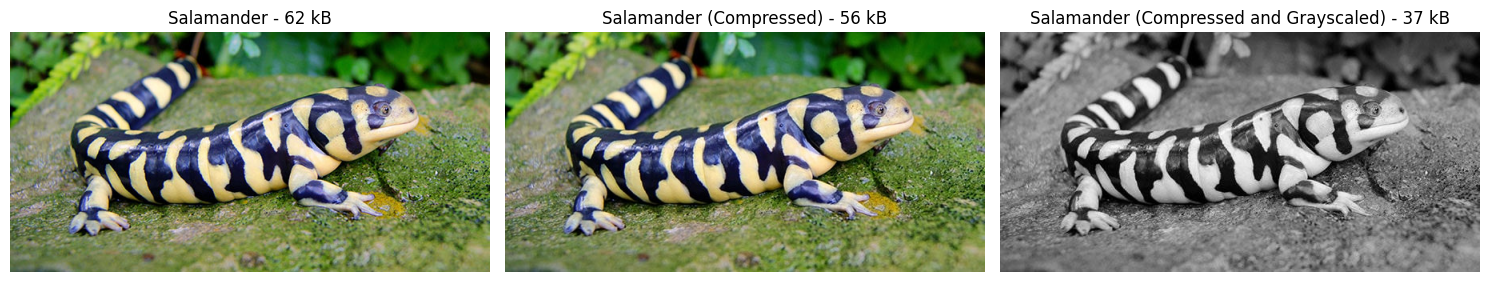

In [1]:
import os
from PIL import Image  # For loading the images
import matplotlib.pyplot as plt  # Plotting library

# Path to the folder containing images
folder_path = "images"

# List of image files
image_files = ['salamander.jpg', 'salamander_compressed.jpg', 'salamander_compressed_grayscale.jpg']

# Load and display the first 3 images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

for i, ax in enumerate(axes):
    image_path = os.path.join(folder_path, image_files[i])
    image = Image.open(image_path)  # Open the image
    ax.imshow(image)  # Show the image
    ax.axis('off')  # Hide axes
    ax.set_title("Salamander - 62 kB" if i == 0 else "Salamander (Compressed) - 56 kB" if i == 1 else "Salamander (Compressed and Grayscaled) - 37 kB")

plt.tight_layout()
plt.show()

# Dimensionality Reduction (PCA motivation) — Continued

Not all examples of dimensionality reduction are as easy to visualize as the image compression and gray scaling example above. Consider the example in the notebook cell below, where the data lies in a slanted circle in a 3-dimensional space. It is clear that the x and y components have a circular relationship with one another, but what about the z component? As shown in the graph, the z component is not playing an important role in describing the data. There is not much variation in the data around the z axis, so we can remove that information. But how?

The 3-dimensional circle casts a 2-dimensional shadow on the x-y plane. If we only keep that shadow, and disregard any variation in the third dimension, we lose almost no information about the pattern of the data, while reducing it from 3 dimensions to 2. 

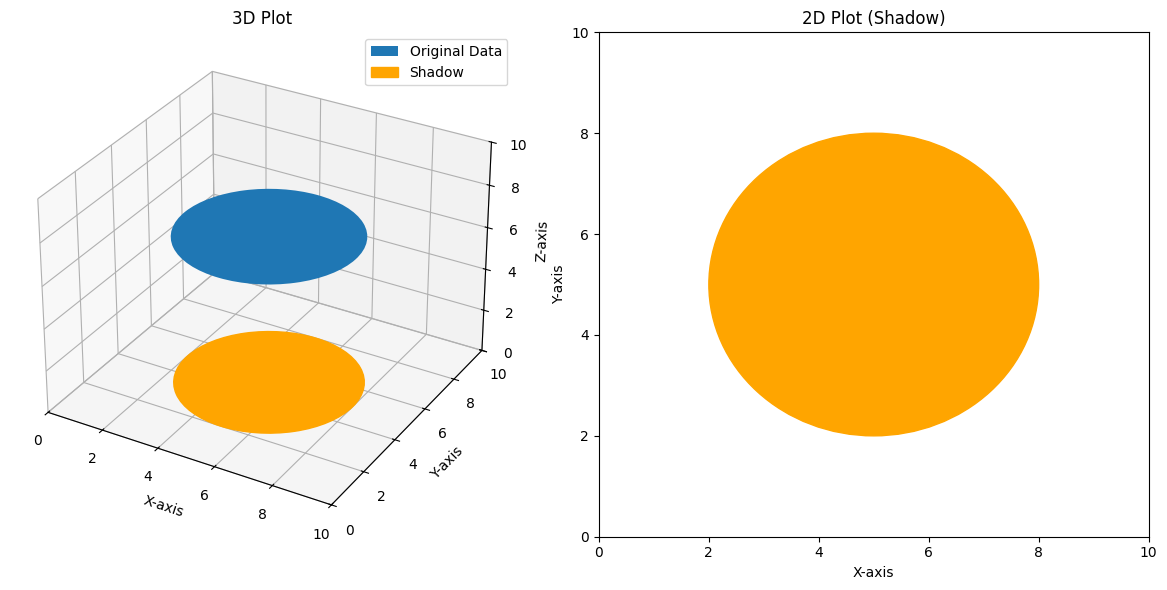

In [18]:
import matplotlib.pyplot as plt  # Plotting library
from matplotlib.patches import Circle, PathPatch  # Plotting circles
import mpl_toolkits.mplot3d.art3d as art3d  # Plotting 3D circle disk

# Create a figure with two subplots side by side
fig = plt.figure(figsize=(12, 6))

# 3D plot
ax1 = fig.add_subplot(1, 2, 1, projection='3d')

# Create 3D circular disk
p1 = Circle((5, 5), 3, label="Original Data")
ax1.add_patch(p1)
art3d.pathpatch_2d_to_3d(p1, z=7)

# Create shadow of circular disk
p2 = Circle((5, 5), 3, color="orange", label="Shadow")
ax1.add_patch(p2)
art3d.pathpatch_2d_to_3d(p2, z=0)

# Set title and axis labels
ax1.set_title('3D Plot')
ax1.set_xlabel('X-axis')
ax1.set_ylabel('Y-axis')
ax1.set_zlabel('Z-axis')

# Set coordinate range of graph
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 10)
ax1.set_zlim(0, 10)

ax1.legend()  # Show plot labels

# 2D plot
p3 = Circle((5, 5), 3, color="orange")
ax2 = fig.add_subplot(1, 2, 2)
ax2.add_patch(p3)

# Set title and axis labels
ax2.set_title('2D Plot (Shadow)')
ax2.set_xlabel('X-axis')
ax2.set_ylabel('Y-axis')

# Set coordinate range of graph
ax2.set_xlim(0, 10)
ax2.set_ylim(0, 10)

# Show the plots
plt.tight_layout()
plt.show()

# What about PCA?

The examples above are employing dimensionality reduction, but they are not employing Principal Component Analysis, as they are relatively simple. PCA is a special dimensionality reduction algorithm used to reduce data where it is not so clear which dimensions to reduce and how. 

Suppose we have a dataset which identifies handwritten digits (we will be extensively covering this example later). Should we remove individual pixels to reduce dimensionality? Probably not, since we do not know which pixels might contain relevant information. Furthermore, pixels that are blank in one image might not be blank in the rest. Our reduction method has to be a bit more sophisticated.

The key insight of PCA is that the values of certain pixels are more correlated than others. If we can deduce these correlations, we can “engineer” new features/columns that each capture the relationship between multiple columns. We can then substitute our sparse original data with a smaller number of information-dense correlation columns, thus reducing the dimensionality. The features in the final dataset are called <b>components</b>. 

## Loading and describing the data

In [3]:
from sklearn.datasets import load_digits  # For loading digits dataset
import pandas as pd  # To store data in a dataframe

digits = load_digits()  # Loads data
print(digits['DESCR'])  # Prints dataset description

X = pd.DataFrame(digits.data, columns=digits.feature_names)  # Loads features into dataframe
y = digits.target  # Loads labels

print(X.shape)
print(y.shape)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 1797
:Number of Attributes: 64
:Attribute Information: 8x8 image of integer pixels in the range 0..16.
:Missing Attribute Values: None
:Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
:Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an in

## Visualizing the data

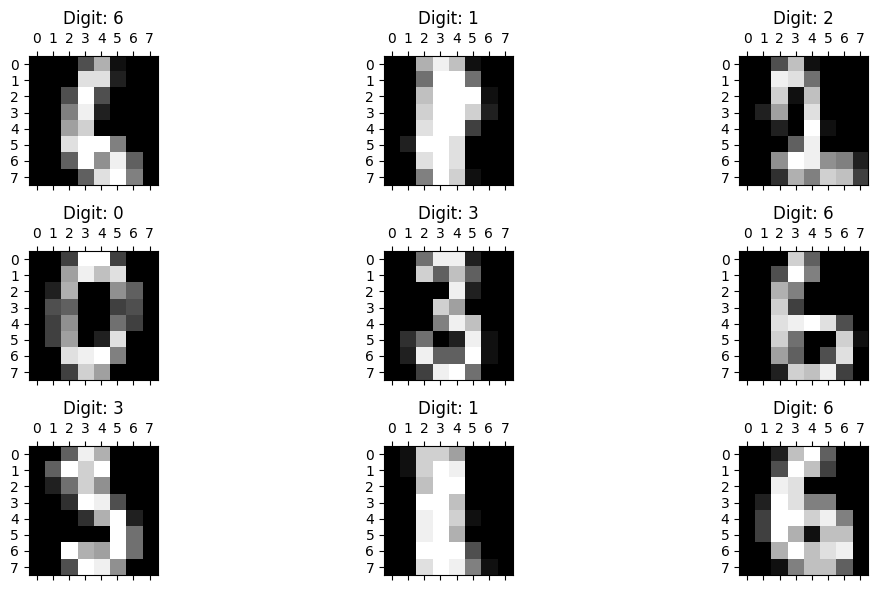

In [7]:
from random import randint  # For random sampling
import numpy as np

fig = plt.figure(figsize=(12, 6))  # Set up the plot
plt.gray()

# Visualize 9 random digits from the dataset
for i in range(9):  
    j = randint(0, len(X.index) - 1)  # Randomly choses a digit from the dataset
    ax = fig.add_subplot(3, 3, i + 1)
    ax.matshow(np.array(X.iloc[j]).reshape(8, 8))  # Reshape 64-pixel digit image into 8 x 8 grid
    ax.set_title(f'Digit: {y[j]}')  # Set the digit associated with the image as the title

plt.tight_layout()
plt.show()

## Train-test splitting, Training, and Testing

As discussed before, the number of features in the final dataset are called the components of the dataset. If we increase the number of components, we would be storing more information about the data, leading to more comprehensive training of the machine learning model, and thus greater classification accuracy. However, storing more data also increases storage requirements. Thus, these two considerations have to be balanced.

Usually, there is a point of diminishing returns beyond a certain number of components (i.e., keeping more components leads to negligible increases in classification accuracy). To test this phenomenon, the following notebook cell performs PCA and classification on the data multiple times. Each time, PCA is performed with a different number of components, and the corresponding classification accuracy is plotted. As we can see, after about 30 components, the classification accuracy barely increases, making 30 components an ideal choice for balancing storage and accuracy.

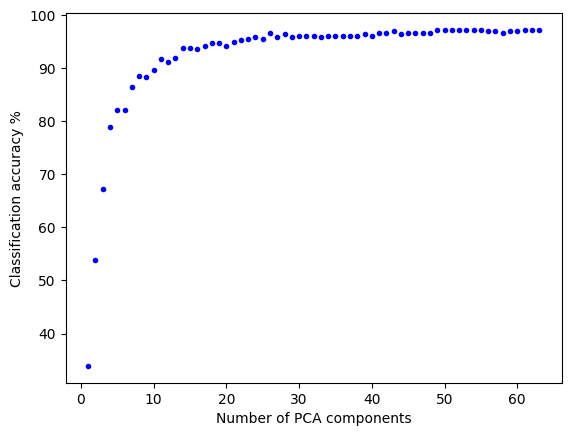

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n_components = []
accuracy = []

for n in range(1, X_scaled.shape[1]):
    pca = PCA(n_components=n)
    X_scaled_pca = pca.fit_transform(X_scaled)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled_pca, y, test_size=0.2, random_state=42)
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    n_components.append(n)
    accuracy.append(logreg.score(X_test, y_test) * 100)

plt.plot(n_components, accuracy, 'bo', markersize=3)
plt.xlabel('Number of PCA components')
plt.ylabel('Classification accuracy %')
plt.show()